# Finetuning Object Detection with Transformers (DETR)

## 1. Import packages.

In [5]:
import argparse
import datetime
import json
import random
import time
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as T
from PIL import Image

import detr.util.misc as utils
from detr.datasets import build_dataset, get_coco_api_from_dataset
from detr.engine import evaluate, train_one_epoch
from detr.models import build_model
import detr.datasets as datasets

from opt import get_args_parser

## 2. Preliminaries for PASCAL VOC dataset and visualization

In [6]:
# PASCAL VOC classes
CLASSES = [
    'background',
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor',
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def draw_bb(img, boxes, color='r'):
    colors = ['r', 'b']
    fig,ax = plt.subplots(1)
    for i, box in enumerate(boxes):
        rect = patches.Rectangle(
            (box[0, 0],box[0, 1]),
            box[0, 2],
            box[0, 3],
            linewidth=3,
            edgecolor=colors[i],
            facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img)

## 3. GIoU

In [7]:
def l2(x, y):
    return ((x - y)**2).sum() ** (1 / 2)

def bbox_iou(box1, box2):
    """
    Returns the IoU of two bounding boxes 
    box 1 : (1, 4) shaped pytorch tensors - sinlge GT bounding box
    box 2 : (N, 4) shaped pytorch tensors - multiple predictions from network
    """
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:,0], box1[:,1], box1[:,0]+box1[:,2], box1[:,1]+box1[:,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:,0], box2[:,1], box2[:,0]+box2[:,2], box2[:,1]+box2[:,3]

    ## intersection rectangle coordinate
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)

    ## intersection area
    inter_area = torch.clamp(inter_rect_x2-inter_rect_x1, min=0.)\
            * torch.clamp(inter_rect_y2-inter_rect_y1, min=0.)

    ## calculate iou
    area_1 = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    area_2 = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
    
    union = (area_1 + area_2 - inter_area)
    iou = inter_area / union

    return iou, union

def generalized_bbox_iou(box1, box2):
    """
    """
    ## practice
    iou, union = bbox_iou(box1, box2)

    lt = torch.min(box1[:, None, :2], box2[:, :2])
    rb = torch.max(box1[:, None, 2:] + box1[:, None, :2], box2[:, 2:] + box2[:, :2])
    
    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    area = wh[:, :, 0] * wh[:, :, 1]

    return iou - (area - union) / area

IoU: 0.25 / loss: 7.42 / GIoU: 0.19 


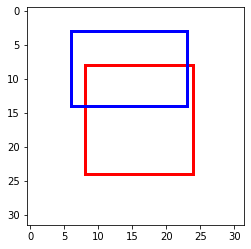

IoU: 0.28 / loss: 8.83 / GIoU: 0.26 


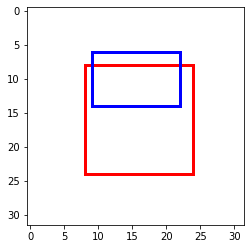

In [11]:
# Example 1

gt_box = torch.Tensor([[8, 8, 16, 16]])

boxes = [
    torch.Tensor([[6, 3, 17, 11]]),
    torch.Tensor([[9, 6, 13, 8]]),
]

img = np.ones([32, 32, 3]) * 255
img = Image.fromarray(img.astype('uint8'), 'RGB')

for box in boxes:
    iou, union = bbox_iou(gt_box, box)
    giou = generalized_bbox_iou(gt_box, box).sum()
    loss = l2(gt_box, box).sum()
    print(f'IoU: {float(iou):.2f} / loss: {float(loss):.2f} / GIoU: {float(giou):.2f} ')
    draw_bb(img, [gt_box, box])
    plt.show()

IoU: 0.00 / loss: 29.43 / GIoU: -0.38 


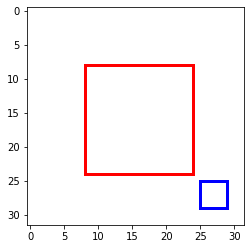

IoU: 0.00 / loss: 31.19 / GIoU: -0.46 


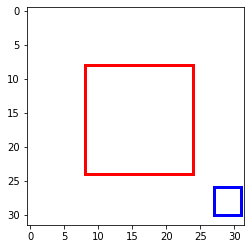

In [15]:
# Example 2

gt_box = torch.Tensor([[8, 8, 16, 16]])

boxes = [
    torch.Tensor([[25, 25, 4, 4]]),
    torch.Tensor([[27, 26, 4, 4]]),
]

img = np.ones([32, 32, 3]) * 255
img = Image.fromarray(img.astype('uint8'), 'RGB')

for box in boxes:
    iou, union = bbox_iou(gt_box, box)
    giou = generalized_bbox_iou(gt_box, box).sum()
    loss = l2(gt_box, box).sum()
    print(f'IoU: {float(iou):.2f} / loss: {float(loss):.2f} / GIoU: {float(giou):.2f} ')
    draw_bb(img, [gt_box, box])
    plt.show()

## 4. Load PASCAL VOC Dataset.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

parser = get_args_parser()
args = parser.parse_known_args()[0]

voc_train = build_dataset(image_set='train', args=args)
voc_val = build_dataset(image_set='val', args=args)

data_loader_train = torch.utils.data.DataLoader(
    voc_train, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    voc_val, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

base_ds = get_coco_api_from_dataset(voc_val)

## 5. Finetuning pre-trained DETR on PASCAL VOC Dataset

### 5-1. Define DETR and criterion.

In [ ]:
# define model, criterion, postprocessors
model, criterion, postprocessors = build_model(args)

pretrained_url = 'https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth'
checkpoint = torch.hub.load_state_dict_from_url(
                pretrained_url, map_location='cpu', check_hash=True)
model.load_state_dict(checkpoint['model'])

print("DETR on COCO Dataset")
print(model.class_embed)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 21  #  class (20) + background

# get number of input features for the classifier
in_features = model.class_embed.in_features

# replace the pre-trained class_embed with a new one
model.class_embed = nn.Linear(in_features, num_classes + 1)

model.to(device)

print("DETR on PASCAL VOC Dataset")
print(model.class_embed)

### 5-2. Define optimizier and lr scheduler.

In [ ]:
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

param_dicts = [
    {
        "params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad],
        "lr": args.lr_backbone,
    },
]

optimizer = torch.optim.AdamW(param_dicts, lr=args.lr, weight_decay=args.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_drop)

### 5-3. Finetuning

In [ ]:
epochs = 5

output_dir = Path('logs')
os.makedirs(output_dir, exist_ok=True)

start_time = time.time()
for epoch in range(epochs):
    train_stats = train_one_epoch(
        model, criterion, data_loader_train, optimizer, device, epoch,
        args.clip_max_norm)
    lr_scheduler.step()
    
    if output_dir:
        checkpoint_paths = [output_dir / 'checkpoint.pth']
        # extra checkpoint before LR drop and every 100 epochs
        if (epoch + 1) % args.lr_drop == 0 or (epoch + 1) % 100 == 0:
            checkpoint_paths.append(output_dir / f'checkpoint{epoch:04}.pth')
        for checkpoint_path in checkpoint_paths:
            utils.save_on_master({
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'args': args,
            }, checkpoint_path)

    test_stats, coco_evaluator = evaluate(
        model, criterion, postprocessors, data_loader_val, base_ds, device, output_dir
    )

    log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                 **{f'test_{k}': v for k, v in test_stats.items()},
                 'epoch': epoch,
                 'n_parameters': n_parameters}

#     if output_dir and utils.is_main_process():
#         with (output_dir / "log.txt").open("a") as f:
#             f.write(json.dumps(log_stats) + "\n")

#     # for evaluation logs
#     if coco_evaluator is not None:
#         (output_dir / 'eval').mkdir(exist_ok=True)
#         if "bbox" in coco_evaluator.coco_eval:
#             filenames = ['latest.pth']
#             if epoch % 50 == 0:
#                 filenames.append(f'{epoch:03}.pth')
#             for name in filenames:
#                 torch.save(coco_evaluator.coco_eval["bbox"].eval,
#                                    output_dir / "eval" / name)

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))

## 6. Visualize Results.

In [ ]:
# Load image
im = Image.open('./VOC2007/JPEGImages/000001.jpg')

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
model.eval().cpu()
outputs = model(img)

# keep only predictions with 0.01+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.1

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)